In [1]:
import importlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.special import expit
import scipy.stats

from mapra import prep

from multiprocessing import Process
from time import sleep

import sklearn
from sklearn import linear_model, metrics
from sklearn.metrics import auc, plot_roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold

sns.set_theme(style='white')

make the line where pairwise is calculated numpy already
1024x barplot showing correlation between change at that position and overall change
the other correlation


cosine similarity
multiply the cosines distances
Spearman correlation


histogram over meaningful positions?
element-wise subtract vectors

or feed both values into an NN and

In [2]:
importlib.reload(prep)
data = prep.dataset()
npr = data.fetch_numpy_distances()
delta_labels = data.order
'''
The first column indicates the metric,
the second the value,
the rest is the embedding diff
'''

/home/quirin/PYTHON/mapra


/home/quirin/PYTHON/mapra/mapra/prep.py:37: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapra/all_sequences_prothermdb.fasta
  warnings.warn('unexpected FASTA filename: ' + str(fasta), RuntimeWarning)


loading from /home/quirin/PYTHON/mapra/pkl/h5_slice_0.pkl


'\nThe first column indicates the metric,\nthe second the value,\nthe rest is the embedding diff\n'

In [41]:
spears = dict()
for i, delta in enumerate(delta_labels):
    # select only matching rows, and ignore the delta column
    dnpr = npr[npr[:, 0] == i, 1:]
    spear, pval = scipy.stats.spearmanr(dnpr, axis=0)
    # only need first line[1:] of output matrix
    spears[delta] = spear[0, 1:]
spears

{'dtemp': array([ 0.11917816,  0.08558531,  0.15808247, ..., -0.0420155 ,
         0.04407386, -0.07219054]),
 'ddg': array([ 0.02027241,  0.04867881,  0.21048373, ..., -0.01711015,
        -0.01872658, -0.07774655]),
 'h2o': array([ 0.09248193,  0.19152187,  0.22394765, ..., -0.0162556 ,
         0.10900918, -0.13531456])}

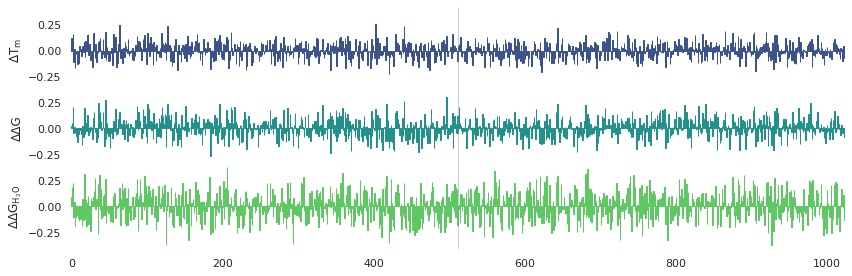

In [49]:
fig, axes = plt.subplots(3, 1, figsize=(12, 4), sharex=True, sharey=True)
for ax, (delta, spear_row), color in zip(
        axes, spears.items(), sns.color_palette('viridis', 3)):
    ax.axvline(x=512, lw=.5, color='.5', alpha=.8)
    ax.bar(x=list(range(1024)), height=spear_row,
           edgecolor=color, label=delta)
ax.set_xlim(-1, 1024)

for delta, ax in zip(delta_labels, axes.flatten()):
    ax.set(ylabel=data.tex_lookup[delta], xlabel='')

axes[2].set(xticks=[i for i in range(1024) if not i % 200])
sns.despine(fig, left=True, bottom=True)
fig.tight_layout()
fig.subplots_adjust(hspace=-.1)

wd = Path('.').resolve().parent / 'plots'
Path.mkdir(wd, parents=True, exist_ok=True)
fig.savefig(wd / f'spearman_correlation_by_h5_index_matplotlib',
          dpi=300, bbox_inches=0)

In [20]:
spd = pd.DataFrame()
spd['x'] = range(1024)

for i, delta in enumerate(delta_labels):
    # select only matching rows, and ignore the delta column
    dnpr = npr[npr[:, 0] == i, 1:]
    spear, pval = scipy.stats.spearmanr(dnpr, axis=0)
    # only need first line[1:] of output matrix
    spd[delta] = spear[0, 1:]

In [21]:
spd.loc[:, delta_labels].corr(method='spearman')

,dtemp,ddg,h2o
dtemp,1.000000,0.768764,0.444120
ddg,0.768764,1.000000,0.530728
h2o,0.444120,0.530728,1.000000


In [22]:
spd = spd.melt(id_vars='x', var_name='delta', value_name='y')
spd


,x,delta,y
0,0,dtemp,0.119178
1,1,dtemp,0.085585
2,2,dtemp,0.158082
3,3,dtemp,-0.108385
4,4,dtemp,0.011450
...,...,...,...
3067,1019,h2o,0.172391
3068,1020,h2o,0.019401
3069,1021,h2o,-0.016256
3070,1022,h2o,0.109009


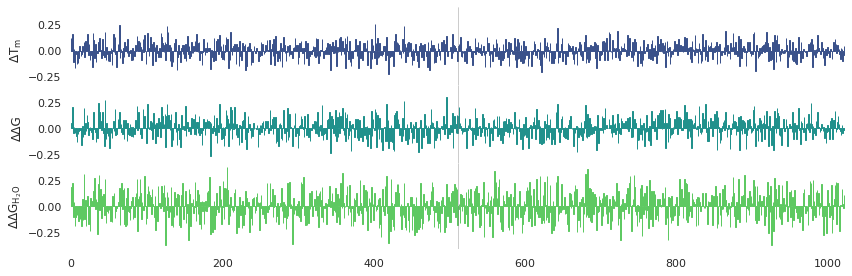

In [50]:
fig, axes = plt.subplots(3, 1, figsize=(12, 4), sharex=True, sharey=True)
for ax, delta, color in zip(
        axes, delta_labels, sns.color_palette('viridis', 3)):
    ax.axvline(x=512, lw=.5, color='.5', alpha=.8)
    sns.barplot(data=spd.loc[spd.delta == delta],
                x='x', y='y', ax=ax,
                facecolor=color,
                linewidth=1, edgecolor=color)
for delta, ax in zip(delta_labels, axes.flatten()):
    ax.set(ylabel=data.tex_lookup[delta], xlabel='')

axes[2].set(xticks=[i for i in range(1024) if not i % 200])
sns.despine(fig, left=True, bottom=True)
fig.tight_layout()
fig.subplots_adjust(hspace=-.1)

wd = Path('.').resolve().parent / 'plots'
Path.mkdir(wd, parents=True, exist_ok=True)
fig.savefig(wd / f'spearman_correlation_by_h5_index',
          dpi=300, bbox_inches=0)